In [1]:
import pandas as pd

In [2]:
import numpy as np 

In [3]:
import matplotlib.pyplot as plt

In [4]:
import plotnine as p9

In [5]:
import scanpy as sc

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200)

In [7]:
import matplotlib.patches as mplpatches

In [32]:
D20_Lineage_assign=pd.read_csv(output_d+'/T5_control/AGG_Day20/outs/count/crispr_analysis/protospacer_calls_per_cell.csv',header=0,sep=',')

In [34]:
D20_Lineage_assign[0:5]

,cell_barcode,num_features,feature_call,num_umis
0,CCGATCTTCCGACGGT-1,1,GENBC0200739,5
1,GACGCTGGTATCTCTT-1,1,GENBC0200739,6
2,GGAATCTGTAAGGCCA-1,1,GENBC0200739,7
3,CAATCGACAAGTGTCT-2,1,GENBC0200739,6
4,GGCACGTAGGAGGCAG-2,1,GENBC0200739,5


In [48]:
D20_Lineage_assign['batch']='0'

In [38]:
clone1_Lineage_assign=pd.read_csv(output_d+'/resist_clone1/GEXandLineage_channel1/outs/crispr_analysis/protospacer_calls_per_cell.csv',header=0,sep=',')

In [49]:
clone1_Lineage_assign['batch']='1'

In [50]:
Lineage_df=pd.concat([D20_Lineage_assign,clone1_Lineage_assign],axis=0)

In [51]:
Lineage_df

,cell_barcode,num_features,feature_call,num_umis,batch
0,CCGATCTTCCGACGGT-1,1,GENBC0200739,5,0
1,GACGCTGGTATCTCTT-1,1,GENBC0200739,6,0
2,GGAATCTGTAAGGCCA-1,1,GENBC0200739,7,0
3,CAATCGACAAGTGTCT-2,1,GENBC0200739,6,0
4,GGCACGTAGGAGGCAG-2,1,GENBC0200739,5,0
...,...,...,...,...,...
4822,TTTGTTGTCCCATACC-1,1,GENBC0283767,32,1
4823,TTTGTTGTCCGACGGT-1,1,GENBC0283767,15,1
4824,TTTGTTGTCGCCTCTA-1,1,GENBC0283767,49,1
4825,TTTGTTGTCGGTATGT-1,1,GENBC0283767,37,1


In [19]:
directorynames=['/T5_control/AGG_Day20/outs/count/filtered_feature_bc_matrix','/resist_clone1/GEXandLineage_channel1/outs/filtered_feature_bc_matrix']

In [ ]:
adata = [sc.read_10x_mtx(directoryname,  
    var_names='gene_symbols',                  
    cache=True,gex_only=False)                                # write a cache file for faster subsequent reading
 for directoryname in [output_d+ d for d in directorynames ]]


In [54]:
adata

[AnnData object with n_obs × n_vars = 25983 × 37244
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5043 × 37244
     var: 'gene_ids', 'feature_types']

In [55]:
sample_names=['D20','Resist_clone1']
for i in range(0,len(adata)):     
    adata[i].obs['sample']=sample_names[i]
    adata[i].obs['cell_bc']=adata[i].obs.index

In [56]:
adata = adata[0].concatenate(adata[1:]) 
len(adata.obs)

31026

In [27]:
adata.var["feature_types"].value_counts()


Gene Expression         36601
CRISPR Guide Capture      643
Name: feature_types, dtype: int64

In [31]:
adata.obs.batch.value_counts()

0    25983
1     5043
Name: batch, dtype: int64

In [62]:
adata.obs=adata.obs.reset_index().merge(Lineage_df,how="left",left_on=["cell_bc",'batch'],right_on=["cell_barcode",'batch']).set_index('index')

In [173]:
adata.obs.dtypes #num_umis is of the object type, probably because when num_features>1, num_umis looks like num_umis1|num_umis2|etc

sample          category
cell_bc         category
batch           category
cell_barcode    category
num_features     float64
feature_call    category
num_umis          object
dtype: object

In [175]:
adata.obs['num_umis']=adata.obs['num_umis'].astype(str)

In [177]:
adata.write(output_d+'/T5_control/Anndata/AggD20andClone1_all.h5ad')

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'num_umis' as categorical


In [64]:
GEX_adata=adata[adata.obs['num_features']==1.0,adata.var["feature_types"] == "Gene Expression"]

In [67]:
sc.pp.calculate_qc_metrics(GEX_adata, inplace=True)

Trying to set attribute `.obs` of view, copying.


In [68]:
ribo_genes = GEX_adata.var_names.str.startswith(('RPS','RPL'))
GEX_adata.obs['percent_ribo'] = np.sum(
    GEX_adata[:, ribo_genes].X, axis=1).A1 / np.sum(GEX_adata.X, axis=1).A1

In [69]:
mito_genes = GEX_adata.var_names.str.startswith(('MT-'))
GEX_adata.obs['percent_mito'] = np.sum(
    GEX_adata[:, mito_genes].X, axis=1).A1 / np.sum(GEX_adata.X, axis=1).A1

In [70]:
sc.pp.normalize_total(GEX_adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [71]:
sc.pp.log1p(GEX_adata)

In [72]:
GEX_adata.raw = GEX_adata
#Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [73]:
sc.pp.highly_variable_genes(GEX_adata, min_mean=0.0125, max_mean=5, min_disp=0.5)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


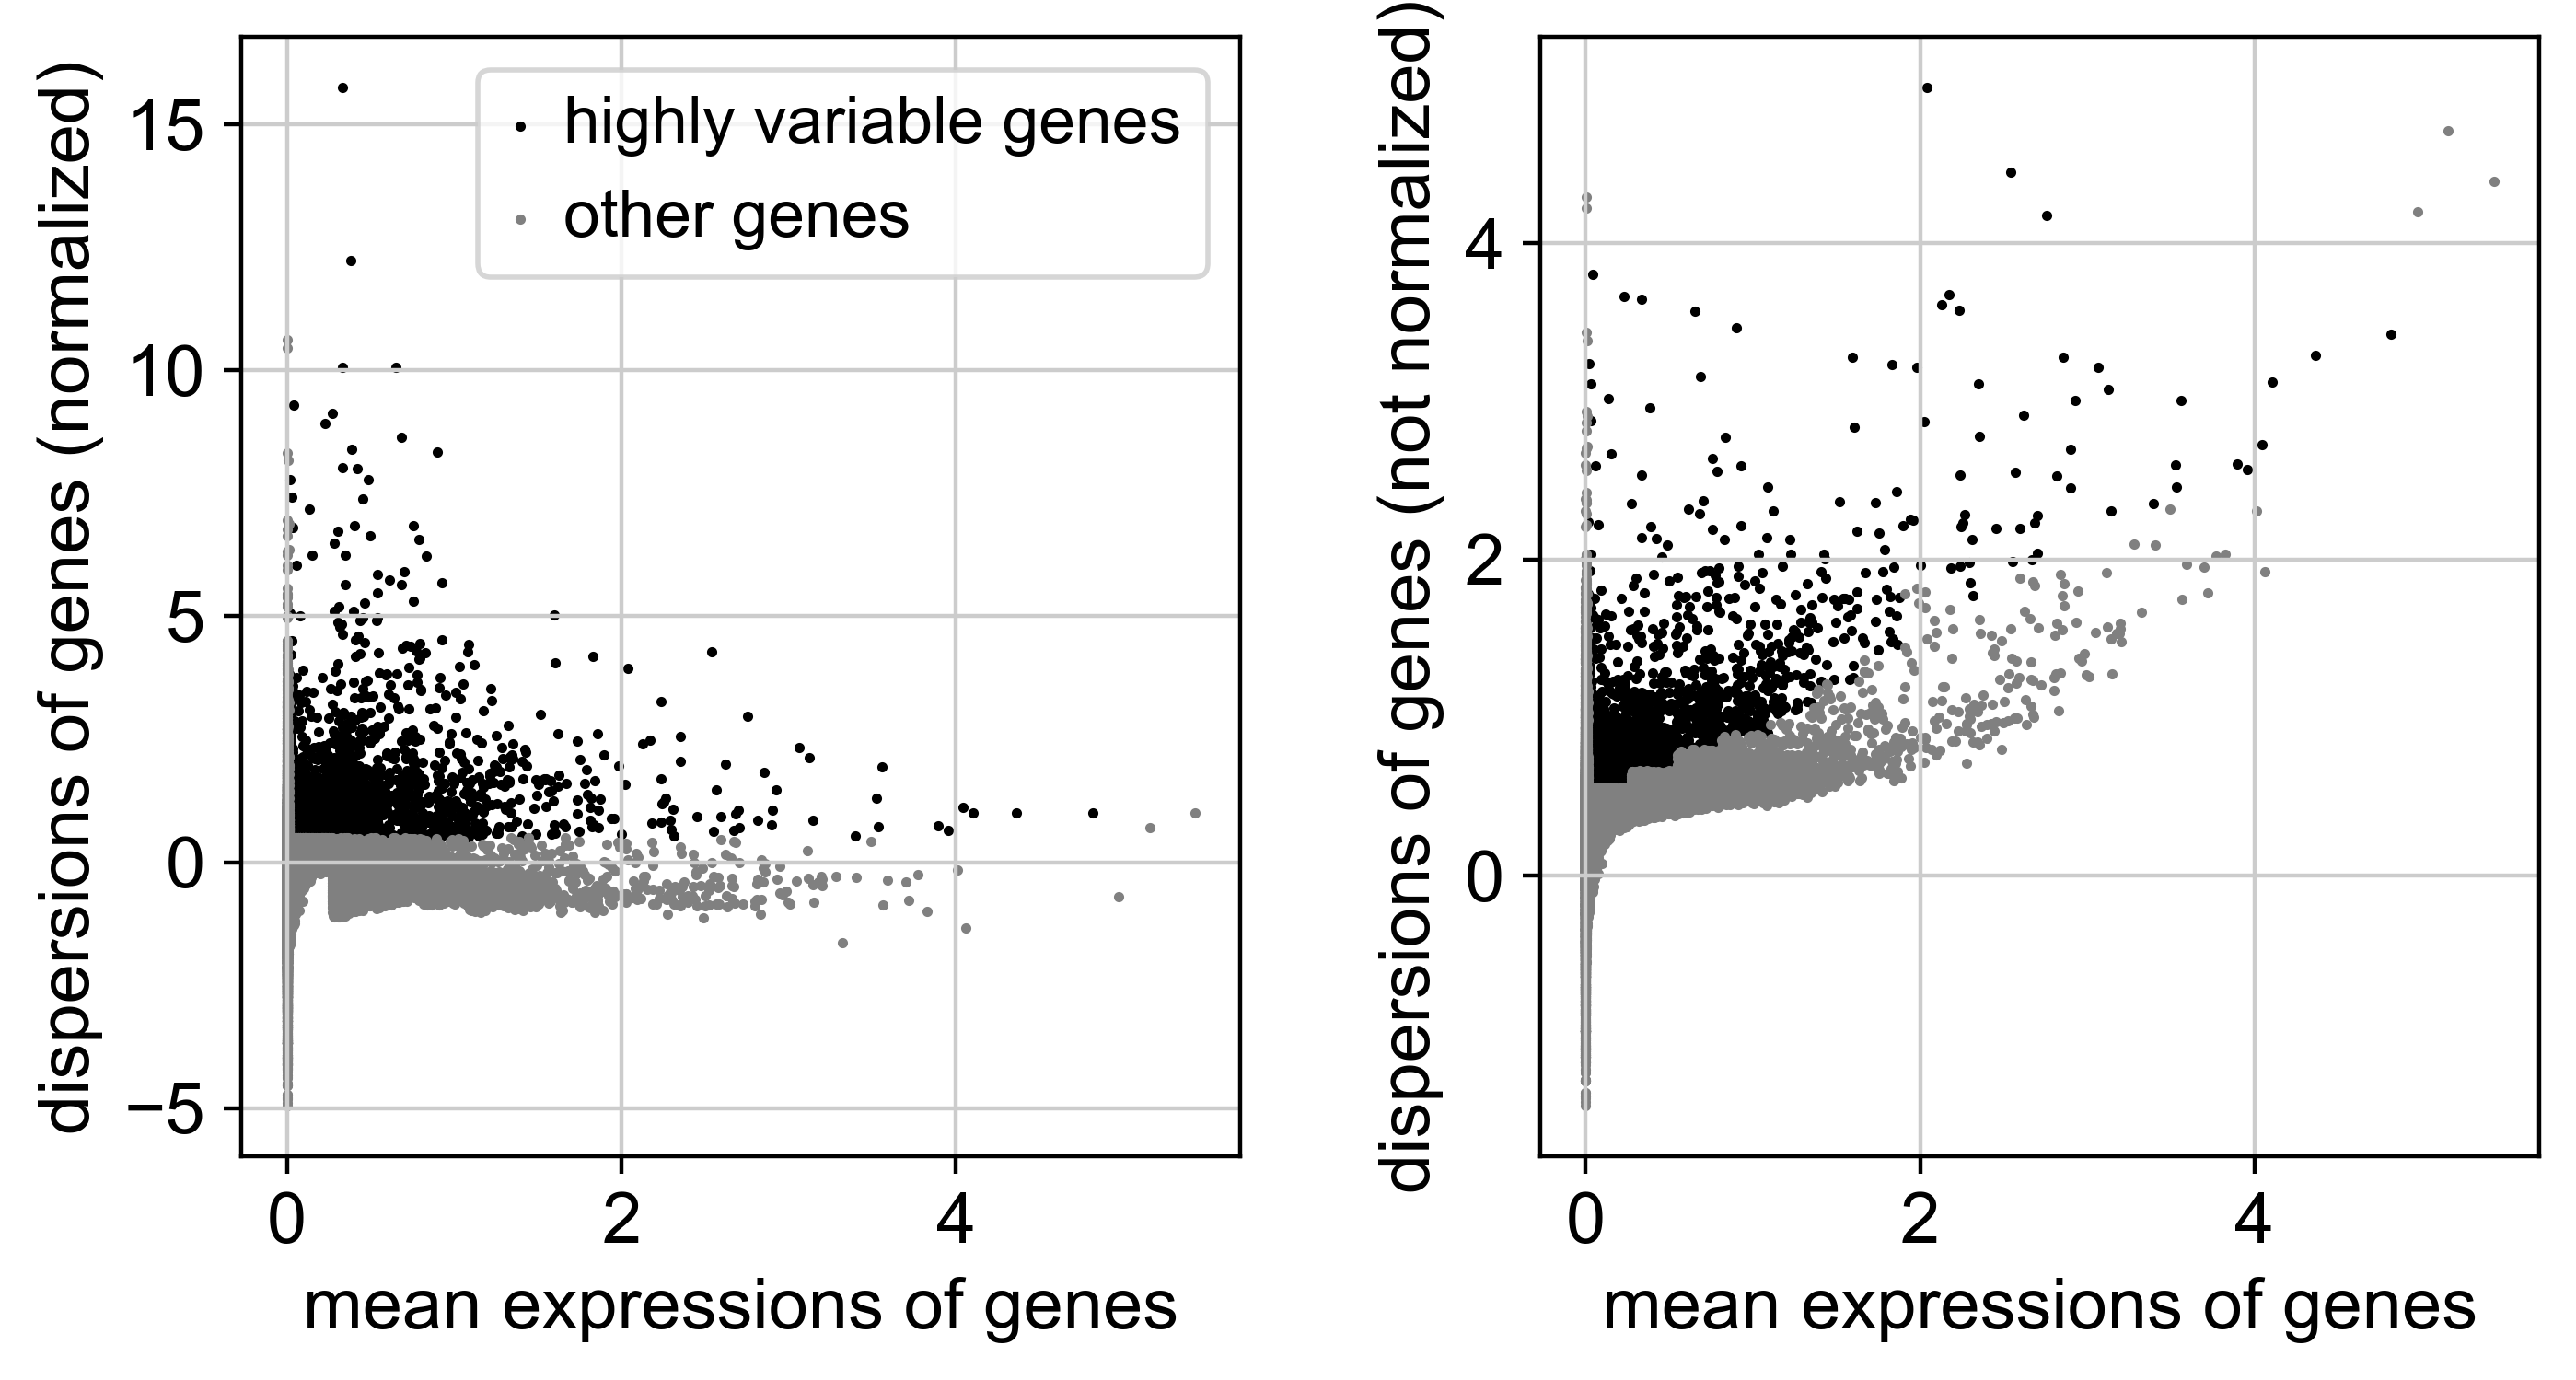

In [74]:
sc.pl.highly_variable_genes(GEX_adata)

In [75]:
sc.pp.scale(GEX_adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [76]:
sc.tl.pca(GEX_adata, svd_solver='arpack',n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


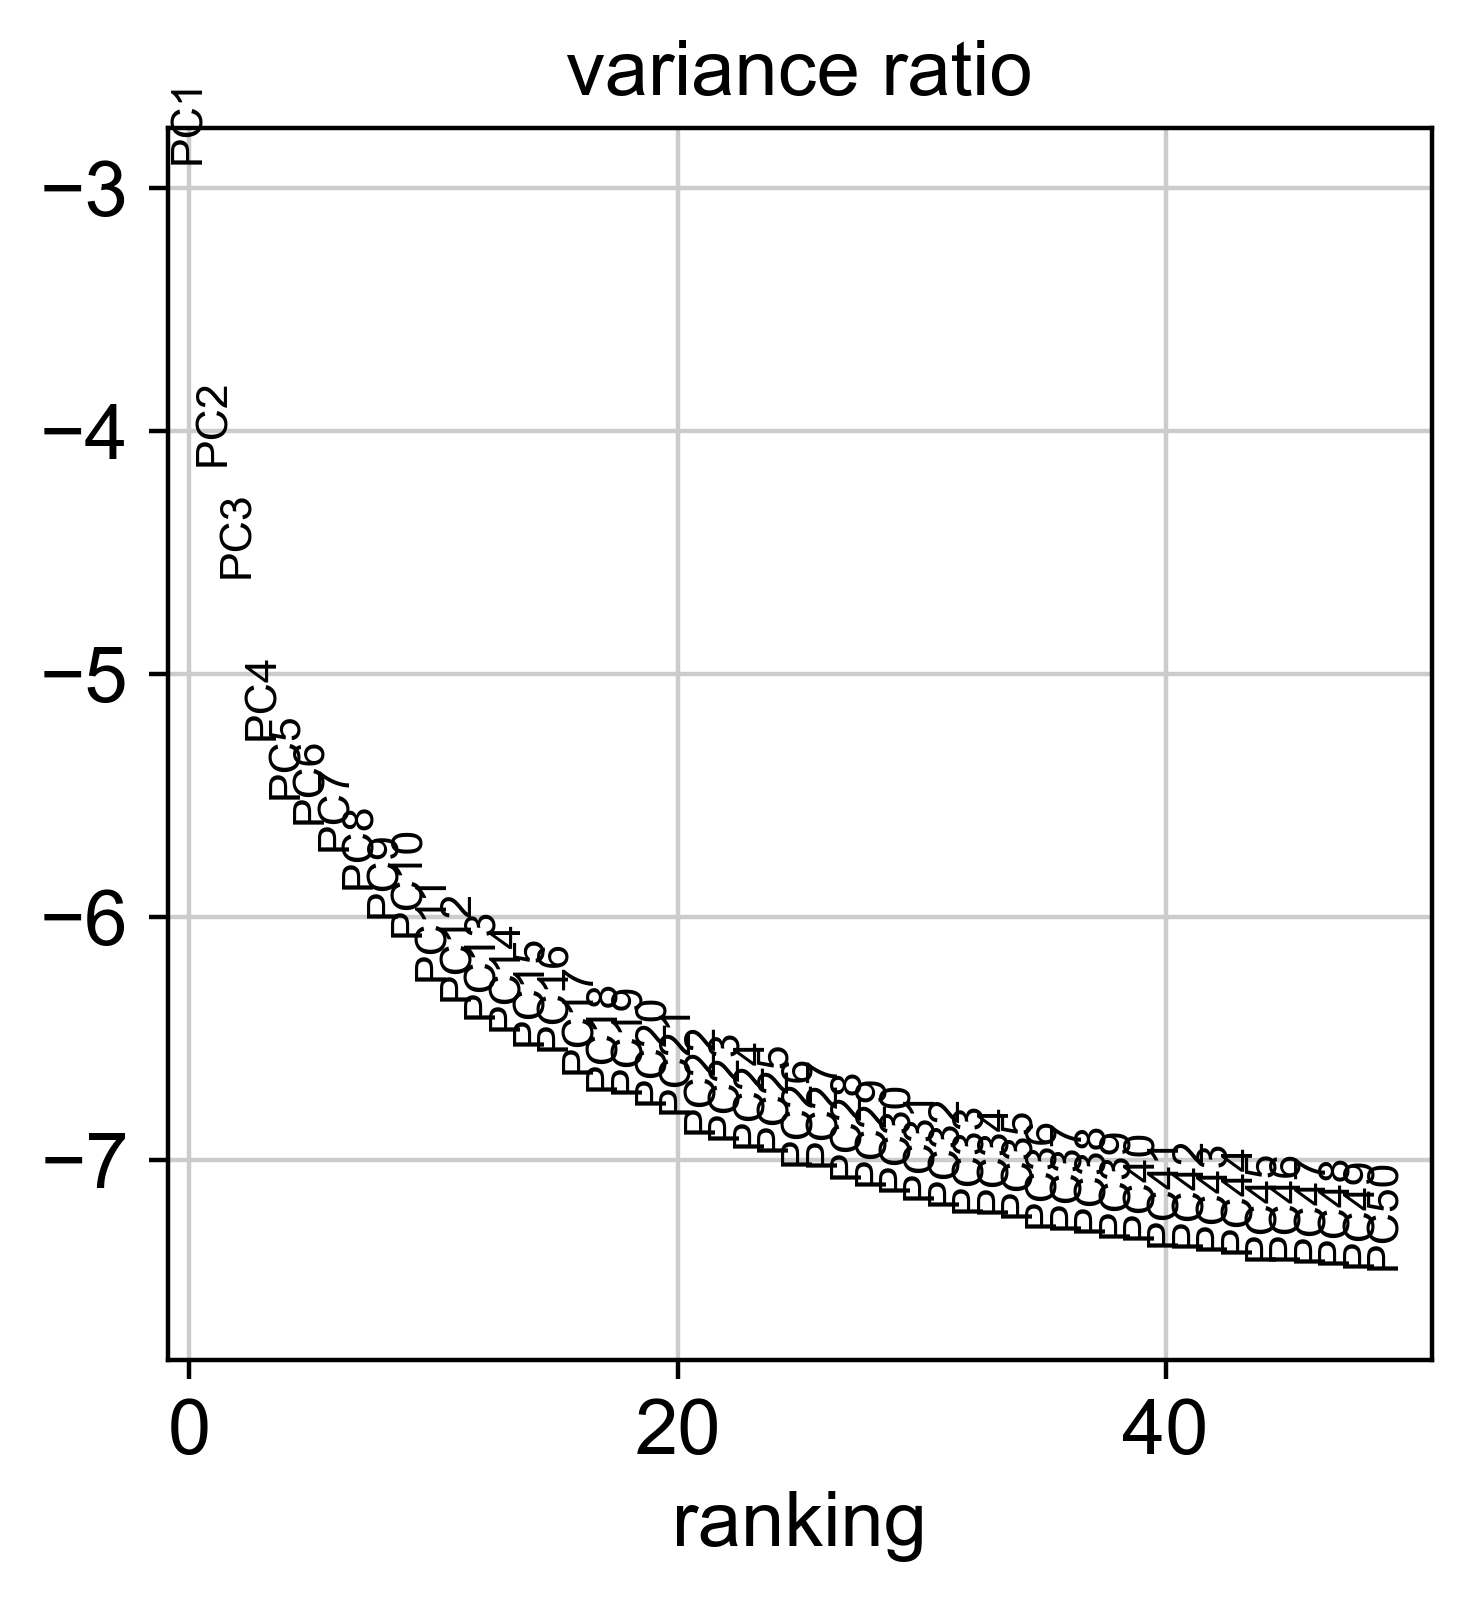

In [77]:
sc.pl.pca_variance_ratio(GEX_adata, log=True,n_pcs=50)

In [78]:
sc.pp.neighbors(GEX_adata, n_neighbors=15, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)


In [79]:
sc.tl.leiden(GEX_adata,resolution=1,key_added="leiden_1")

running Leiden clustering
    finished: found 20 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:00:05)


In [80]:
sc.tl.paga(GEX_adata,groups='leiden_1')
sc.pl.paga(GEX_adata, plot=False) 
sc.tl.umap(GEX_adata,init_pos='paga')

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'cell_bc' as categorical
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categori

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


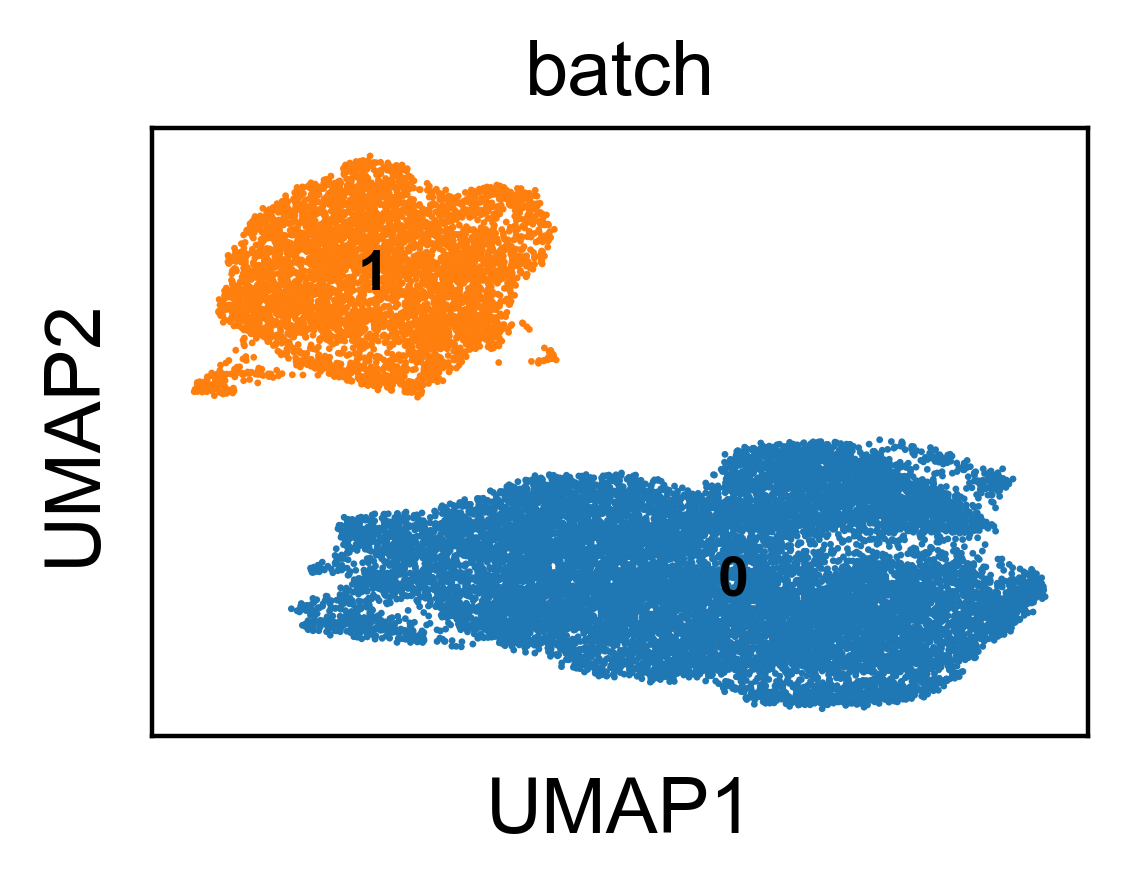

In [83]:
with plt.rc_context({'figure.figsize': (3, 2),"font.size":10}):
    sc.pl.umap(GEX_adata, color=['batch' ]
           ,ncols=1,legend_loc='on data')

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.


the obs value 'feature_call' has more than 103 categories. Uniform 'grey' color will be used for all categories.


/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


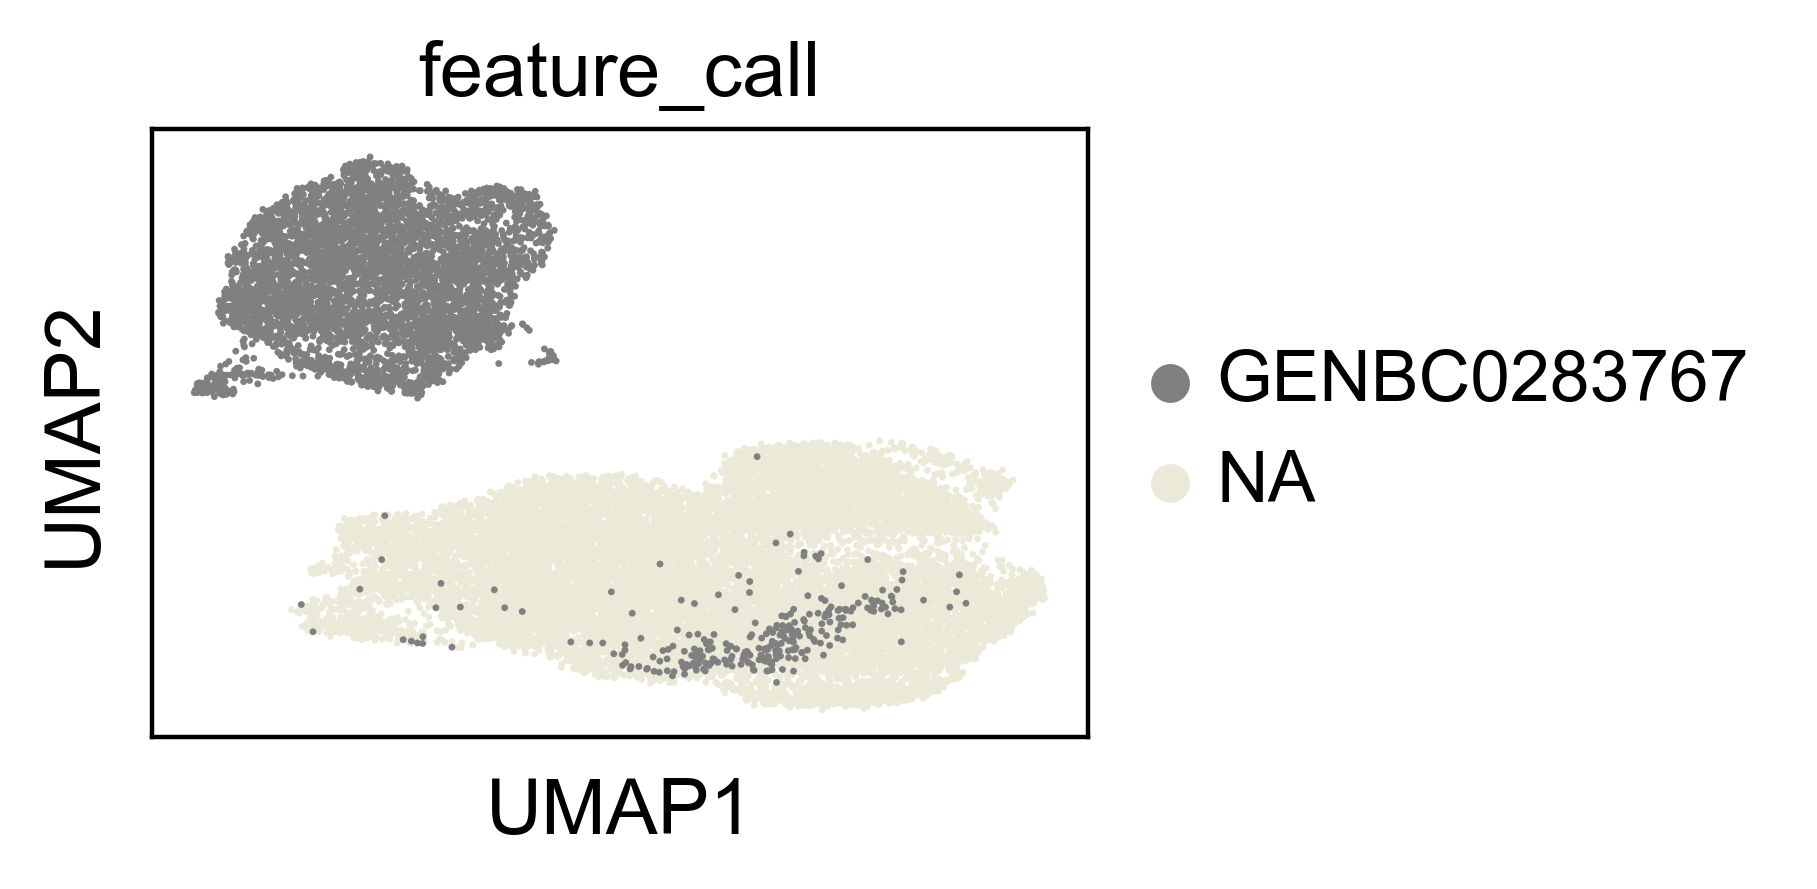

In [85]:
with plt.rc_context({'figure.figsize': (3, 2),"font.size":10}):
    sc.pl.umap(GEX_adata, color=['feature_call' ],groups=['GENBC0283767']
           ,ncols=1,legend_loc='right margin',na_color='#EBE9D8')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:21)


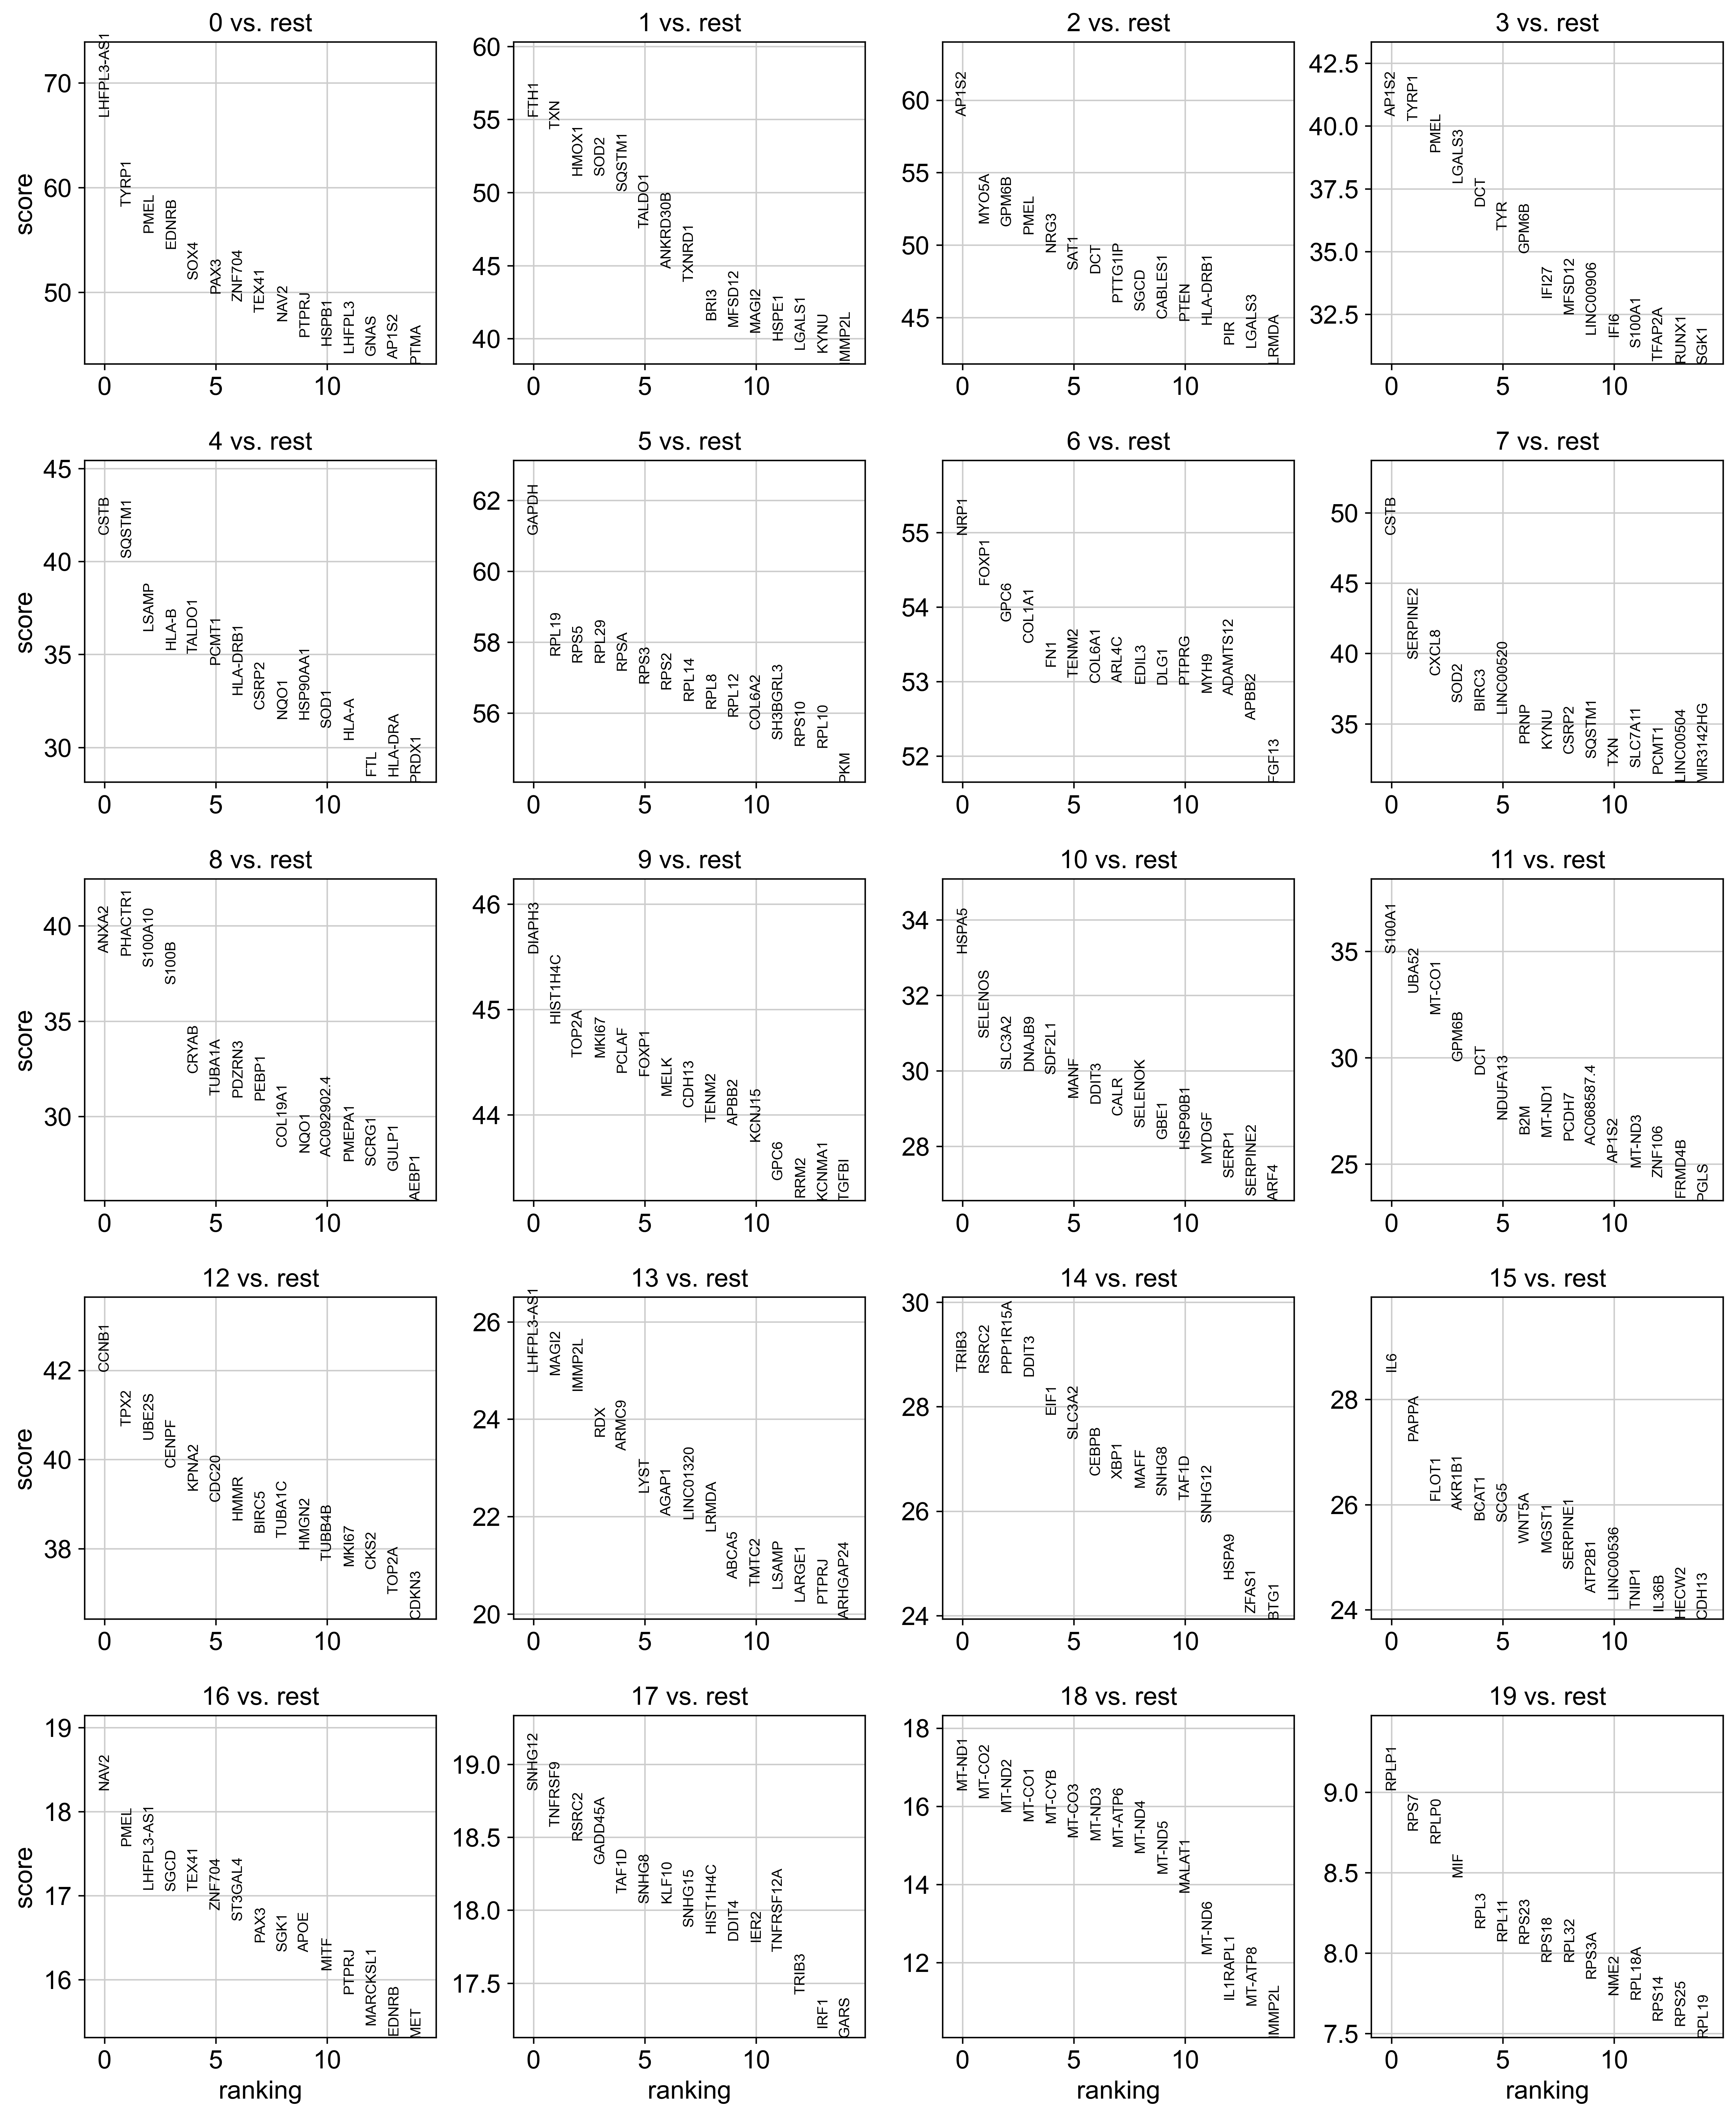

In [94]:
sc.tl.rank_genes_groups(GEX_adata, 'leiden_1', method='wilcoxon')
sc.pl.rank_genes_groups(GEX_adata, n_genes=15, sharey=False)

In [105]:
GEX_adata.obs['is_clone1_lineage']='Others'

In [106]:
GEX_adata.obs.loc[GEX_adata.obs['feature_call']=='GENBC0283767','is_clone1_lineage'] = 'Clone1_Lineage' 

In [181]:
GEX_adata.write(output_d+'/T5_control/Anndata/AggD20andClone1_LineageFiltered_GEX.h5ad')

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'num_umis' as categorical
